In [288]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from poker_utils.model import (analyze_embeddings, 
                               save_model_and_embeddings, evaluate_hand_hand_equity, 
                               prob_embeddings)
from itertools import combinations_with_replacement

In [289]:

ranks = 'AKQJT98765432'
hands = []
for i, r1 in enumerate(ranks):
    for j, r2 in enumerate(ranks):
        if i < j:
            hands.append(r1 + r2 + 's')  
            hands.append(r1 + r2 + 'o')  
        elif i == j:
            hands.append(r1 + r2) 

hands = sorted(hands)
n = len(hands)

def are_similar(h1, h2):
    def hand_features(h):
        if len(h) == 2:
            return h[0], h[1], 'p'
        r1, r2, s = h[0], h[1], h[2]
        return r1, r2, s

    r1a, r2a, ta = hand_features(h1)
    r1b, r2b, tb = hand_features(h2)

    same_rank = r1a == r1b or r2a == r2b
    same_type = ta == tb
    close = abs(ranks.index(r1a) - ranks.index(r1b)) <= 1 and abs(ranks.index(r2a) - ranks.index(r2b)) <= 1

    return same_rank or same_type or close

similarity_matrix = np.zeros((n, n), dtype=int)

for i in range(n):
    for j in range(n):
        if i == j or are_similar(hands[i], hands[j]):
            similarity_matrix[i, j] = 1


similarity_labels = pd.DataFrame(similarity_matrix, index=hands, columns=hands)

In [290]:
base_data = pd.read_csv("data/raw/base_hand_data.csv").set_index("hand")
blocker_data = pd.read_csv("data/raw/preflop_block_data.csv").set_index('hand')
ev_data = pd.read_csv('data/raw/ev_pca_data.csv').set_index('hand').filter(regex="play")
equity_data = pd.read_csv("data/processed/equity_totals.csv").set_index("hand")
equity_matrix = pd.read_csv("data/processed/equity_matrix.csv")


In [291]:
full_data = pd.concat(
    [base_data, 
     blocker_data, 
     equity_data, 
     ev_data], axis=1)

In [292]:
cols = [
    'suited', 'connectedness', 'pair', 'high_card', 'low_card',
    'rank_diff', 'ace', 'broadway', 'low_pair', 'medium_pair',
    'high_pair', 'broadway_score', 'suited_broadway',
    'suited_broadway_score', 'connector', 'one_gap', 'two_gap',
    'suited_connector', 'suited_one_gap', 'suited_two_gap',
    'connectedness_score', 'rank_diff_score', 'high_card_score',
    'low_card_score', 'suited_connected_score',
       
    'block_aa', 'block_kk', 'block_qq', 'block_ak', 'block_aq',
    'prem_blocker_score', 'prem_blocker_score_norm', 'block_aa_score',
    'block_kk_score',
       
    'tot_win_perc', 'high_card_win_perc',
    'one_pair_win_perc', 'two_pair_win_perc', 'three_of_a_kind_win_perc',
    'straight_win_perc', 'flush_win_perc', 'full_house_win_perc',
    'four_of_a_kind_win_perc', 'straight_flush_win_perc',
    'straight_win_potential', 'flush_win_potential', 'value_win_potential',
    'highcard_win_potential',
       
    'BB_play10', 'BB_play2', 'BB_play3', 'BB_play4', 'BB_play5', 'BB_play6',
    'BB_play7', 'BB_play8', 'BB_play9', 'D_play10', 'D_play3', 'D_play4',
    'D_play5', 'D_play6', 'D_play7', 'D_play8', 'D_play9', 'SB_play10',
    'SB_play2', 'SB_play3', 'SB_play4', 'SB_play5', 'SB_play6', 'SB_play7',
    'SB_play8', 'SB_play9', 'pos3_play10', 'pos3_play4', 'pos3_play5',
    'pos3_play6', 'pos3_play7', 'pos3_play8', 'pos3_play9', 'pos4_play10',
    'pos4_play5', 'pos4_play6', 'pos4_play7', 'pos4_play8', 'pos4_play9',
    'pos5_play10', 'pos5_play6', 'pos5_play7', 'pos5_play8', 'pos5_play9',
    'pos6_play10', 'pos6_play7', 'pos6_play8', 'pos6_play9', 'pos7_play10',
    'pos7_play8', 'pos7_play9', 'pos8_play10', 'pos8_play9', 'pos9_play10'
]

In [293]:
scaler = StandardScaler()
X = np.concat([full_data[cols].to_numpy(), equity_matrix.set_index("hand").to_numpy()],axis=1)
X_scaled = scaler.fit_transform(X)

In [294]:
X_scaled = torch.tensor(X_scaled, dtype=torch.float32)

In [295]:

class ContrastiveEncoder(nn.Module):
    def __init__(self, input_dim=271, embedding_dim=32, proj_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim)
        )
        self.projection_head = nn.Sequential(
            nn.Linear(embedding_dim, proj_dim),
            nn.ReLU(),
            nn.Linear(proj_dim, proj_dim)
        )

    def forward(self, x):
        embedding = self.encoder(x)
        proj = self.projection_head(embedding)
        proj = F.normalize(proj, p=2, dim=1)
        return embedding, proj

    

In [296]:
def contrastive_loss(proj, sim_matrix, temperature=0.1):
    similarity = torch.matmul(proj, proj.T)
    logits = similarity / temperature

    mask = torch.eye(sim_matrix.shape[0]).bool()
    sim_matrix = sim_matrix.masked_fill(mask, 0)

    exp_logits = torch.exp(logits)
    log_prob = logits - torch.log(exp_logits.sum(dim=1, keepdim=True) + 1e-12)

    loss = - (sim_matrix * log_prob).sum(dim=1) / sim_matrix.sum(dim=1).clamp(min=1)
    return loss.mean()


In [297]:
def equity_similarity_loss(embeddings, equity_matrix, temperature=0.1):
    emb_sim = F.cosine_similarity(embeddings.unsqueeze(1), embeddings.unsqueeze(0), dim=-1)  # [N, N]
    equity_sim = F.cosine_similarity(equity_matrix.unsqueeze(1), equity_matrix.unsqueeze(0), dim=-1)  # [N, N]

    loss = F.mse_loss(emb_sim, equity_sim)
    return loss


In [298]:
model = ContrastiveEncoder(embedding_dim=32)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [299]:
sim_matrix = torch.tensor(similarity_labels.to_numpy())
equity_mat = torch.tensor(equity_matrix.set_index('hand').to_numpy(), dtype=torch.float32)

In [ ]:

epochs = 200
alpha = 0
losses = []
model.train()
for epoch in range(epochs):
    embeddings, proj = model(X_scaled)
    loss_struct = contrastive_loss(proj, sim_matrix)
    loss_equity = equity_similarity_loss(embeddings, equity_mat)
    loss = loss_struct + alpha * loss_equity

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % (epochs//5) == 0 or epoch == epochs-1:
         print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")



Epoch 1/200, Loss: 5.1702
Epoch 41/200, Loss: 4.8683
Epoch 81/200, Loss: 4.8564
Epoch 121/200, Loss: 4.8468
Epoch 161/200, Loss: 4.8416
Epoch 200/200, Loss: 4.8393


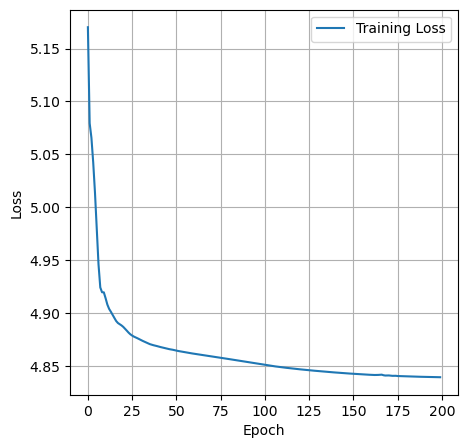

In [301]:
plt.figure(figsize=(5,5))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [302]:
model.eval()
with torch.no_grad():
    embedding, proj = model(X_scaled)
    embeddings = F.normalize(embedding)

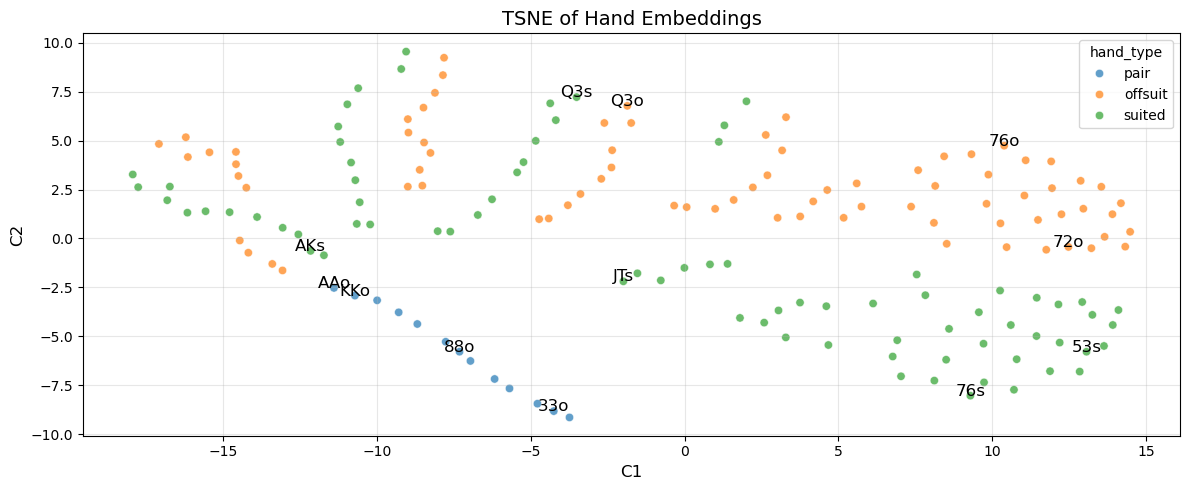

   hand         top_1         top_2         top_3       bottom_1  \
0   AAo  KKo (0.9340)  QQo (0.8789)  AKs (0.8755)   97o (0.0290)   
1   KKo  AAo (0.9340)  QQo (0.9256)  JJo (0.8226)   85s (0.0153)   
2   72o  62o (0.9834)  82o (0.9827)  52o (0.9545)   AQs (0.0333)   
3   76s  75s (0.9372)  65s (0.9277)  86s (0.9249)   QQo (0.0342)   
4   76o  75o (0.9524)  86o (0.9476)  65o (0.9282)   A3s (0.0179)   
5   Q3s  Q4s (0.8761)  Q3o (0.8526)  Q2s (0.8485)   T6o (0.1797)   
6   Q3o  Q4o (0.9037)  J3o (0.8611)  Q3s (0.8526)   A8s (0.2066)   
7   88o  99o (0.9305)  77o (0.9195)  TTo (0.7655)   K2s (0.2145)   
8   JTs  J9s (0.9142)  J8s (0.8850)  T9s (0.8478)   44o (0.1742)   
9   33o  44o (0.8880)  22o (0.7980)  55o (0.6277)  T7s (-0.0551)   
10  AKs  AQs (0.9726)  AJs (0.9420)  ATs (0.9277)  96o (-0.0408)   
11  53s  43s (0.9789)  63s (0.9548)  64s (0.9456)   JTo (0.1439)   

         bottom_2       bottom_3  
0    98o (0.0264)  96s (-0.0043)  
1    96s (0.0104)   87s (0.0087)  
2    ATs (

In [303]:
similarity_df = analyze_embeddings(
    embeddings, 
    hands_of_interest=['AAo','KKo','72o','76s','76o','Q3s',"Q3o",'88o','JTs','33o',"AKs","53s"],
    hand_feature_to_color='hand_type',
    figsize=(12,5)
    )

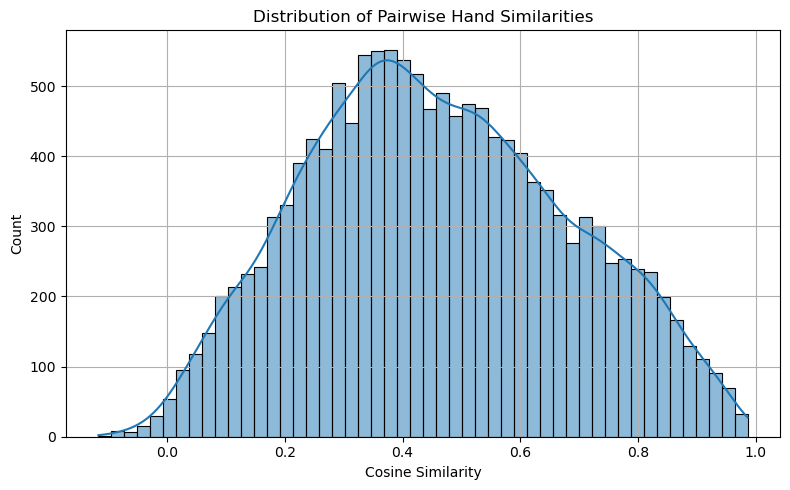

In [304]:
mask = np.triu(np.ones(similarity_df.shape), k=1).astype(bool)
pairwise_sims = similarity_df.where(mask)

all_similarities = pairwise_sims.stack().values

plt.figure(figsize=(8, 5))
sns.histplot(all_similarities, bins=50, kde=True)
plt.title("Distribution of Pairwise Hand Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [305]:
evaluate_hand_hand_equity(embeddings, equity_matrix.set_index('hand').to_numpy())

{'spear_corr': np.float64(0.6144845580036644), 'pval': np.float64(0.0)}

In [306]:
prob_data = pd.read_csv('data/processed/prob_data.csv')

In [307]:
prob_res = prob_embeddings(embeddings, prob_data)

In [312]:
prob_res.sort_values(by='accuracy')

,attribute,class,accuracy,precision,recall,f1_score,support_frac,rmse
77,two_gap,1,0.940828,1.000000,0.545455,0.705882,0.130178,NaN
76,two_gap,0,0.940828,0.936306,1.000000,0.967105,0.869822,NaN
83,suited_two_gap,1,0.952663,1.000000,0.272727,0.428571,0.065089,NaN
82,suited_two_gap,0,0.952663,0.951807,1.000000,0.975309,0.934911,NaN
3,connectedness,1,0.958580,1.000000,1.000000,1.000000,0.153846,NaN
...,...,...,...,...,...,...,...,...
59,pos7_play8,NaN,NaN,NaN,NaN,NaN,NaN,0.183380
60,pos7_play9,NaN,NaN,NaN,NaN,NaN,NaN,0.191298
61,pos8_play10,NaN,NaN,NaN,NaN,NaN,NaN,0.196207
62,pos8_play9,NaN,NaN,NaN,NaN,NaN,NaN,0.193483


In [309]:
prob_res[prob_res.attribute == 'suited_broadway']

,attribute,class,accuracy,precision,recall,f1_score,support_frac,rmse
69,suited_broadway,0,1.0,1.0,1.0,1.0,0.704142,NaN
70,suited_broadway,1,1.0,1.0,1.0,1.0,0.236686,NaN
71,suited_broadway,2,1.0,1.0,1.0,1.0,0.059172,NaN


In [315]:
prob_res[prob_res.attribute.str.contains("play")]

,attribute,class,accuracy,precision,recall,f1_score,support_frac,rmse
10,BB_play10,NaN,NaN,NaN,NaN,NaN,NaN,0.212124
11,BB_play2,NaN,NaN,NaN,NaN,NaN,NaN,0.101762
12,BB_play3,NaN,NaN,NaN,NaN,NaN,NaN,0.146266
13,BB_play4,NaN,NaN,NaN,NaN,NaN,NaN,0.161420
14,BB_play5,NaN,NaN,NaN,NaN,NaN,NaN,0.181220
15,BB_play6,NaN,NaN,NaN,NaN,NaN,NaN,0.200003
16,BB_play7,NaN,NaN,NaN,NaN,NaN,NaN,0.219753
17,BB_play8,NaN,NaN,NaN,NaN,NaN,NaN,0.188222
18,BB_play9,NaN,NaN,NaN,NaN,NaN,NaN,0.205696
19,D_play10,NaN,NaN,NaN,NaN,NaN,NaN,0.206853


In [ ]:
# prob_res.to_csv("results/prob_preflop_contrastiveencoder.csv", index=False)
# similarity_df.reset_index().rename({"index":'hand'},axis=1).to_csv(
#     "results/sim_preflop_contrastiveencoder.csv", index=False)

In [ ]:
# save_model_and_embeddings(
#     embeddings,
#     'preflop_contrastiveencoder_embeddings',
#     model,
#     "preflop_contrastiveencoder_weights"
#     )